In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])


In [3]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [4]:
maze

array([[1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1.],
       [0., 0., 1., 0., 0., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 1.],
       [1., 1., 0., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 1., 1.]])

In [5]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [14]:

def qtrain(model, maze, **opt):
    
    global epsilon
    global a1
    global a
    global b
    global b1
    global c,d,e,f,c1,d1,e1,f1
    a1=[]
    b1=[]
    c1=[]
    d1=[]
    e1=[]
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
     

        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        plt.figure() # In this example, all the plots will be in one figure. 
        
        a=epoch
        b=loss
        c=win_rate
        d=n_episodes
        
        plt.plot(a,b,'r')
        '''   a1=[a,a1]
        b1=[b,b1]
       '''' print(a1)
        #print(b1)'''
        a1.append(a)
        b1.append(b)
        c1.append(c)
        d1.append(d)''''
        show(qmaze)
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds
    plt.show()
# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [15]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [23]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

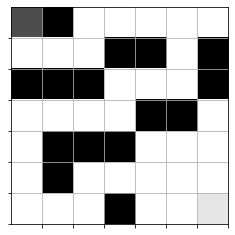

In [24]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

In [25]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

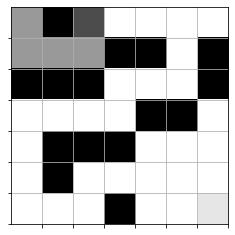

In [26]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [27]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [28]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

Epoch: 000/14999 | Loss: 0.0013 | Episodes: 119 | Win count: 0 | Win rate: 0.000 | time: 6.0 seconds
Epoch: 001/14999 | Loss: 0.0019 | Episodes: 109 | Win count: 0 | Win rate: 0.000 | time: 12.8 seconds
Epoch: 002/14999 | Loss: 0.0021 | Episodes: 102 | Win count: 0 | Win rate: 0.000 | time: 19.0 seconds
Epoch: 003/14999 | Loss: 0.0431 | Episodes: 109 | Win count: 0 | Win rate: 0.000 | time: 25.7 seconds
Epoch: 004/14999 | Loss: 0.0015 | Episodes: 103 | Win count: 0 | Win rate: 0.000 | time: 32.0 seconds
Epoch: 005/14999 | Loss: 0.0019 | Episodes: 112 | Win count: 0 | Win rate: 0.000 | time: 38.9 seconds
Epoch: 006/14999 | Loss: 0.0524 | Episodes: 105 | Win count: 0 | Win rate: 0.000 | time: 45.9 seconds
Epoch: 007/14999 | Loss: 0.0447 | Episodes: 103 | Win count: 0 | Win rate: 0.000 | time: 52.4 seconds
Epoch: 008/14999 | Loss: 0.0024 | Episodes: 109 | Win count: 0 | Win rate: 0.000 | time: 59.0 seconds
Epoch: 009/14999 | Loss: 0.0022 | Episodes: 1 | Win count: 1 | Win rate: 0.000 | ti

c:\users\shreya kohli\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Epoch: 021/14999 | Loss: 0.0013 | Episodes: 104 | Win count: 7 | Win rate: 0.000 | time: 107.5 seconds
Epoch: 022/14999 | Loss: 0.0505 | Episodes: 106 | Win count: 7 | Win rate: 0.000 | time: 114.7 seconds
Epoch: 023/14999 | Loss: 0.0034 | Episodes: 13 | Win count: 8 | Win rate: 0.000 | time: 115.4 seconds
Epoch: 024/14999 | Loss: 0.0537 | Episodes: 1 | Win count: 9 | Win rate: 0.375 | time: 115.5 seconds
Epoch: 025/14999 | Loss: 0.0025 | Episodes: 108 | Win count: 9 | Win rate: 0.375 | time: 122.0 seconds
Epoch: 026/14999 | Loss: 0.0457 | Episodes: 9 | Win count: 10 | Win rate: 0.417 | time: 122.5 seconds
Epoch: 027/14999 | Loss: 0.0020 | Episodes: 7 | Win count: 11 | Win rate: 0.458 | time: 123.1 seconds
Epoch: 028/14999 | Loss: 0.0026 | Episodes: 102 | Win count: 11 | Win rate: 0.458 | time: 129.4 seconds
Epoch: 029/14999 | Loss: 0.0064 | Episodes: 79 | Win count: 12 | Win rate: 0.500 | time: 134.7 seconds
Epoch: 030/14999 | Loss: 0.0041 | Episodes: 104 | Win count: 12 | Win rate: 0

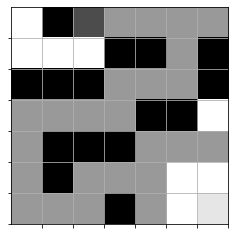

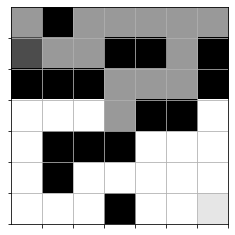

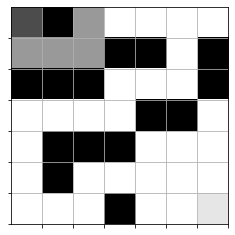

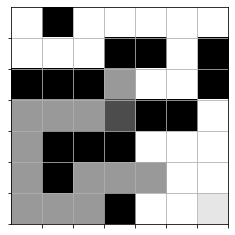

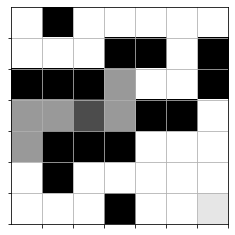

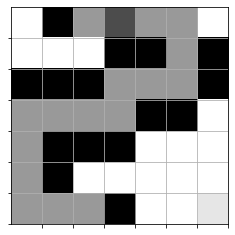

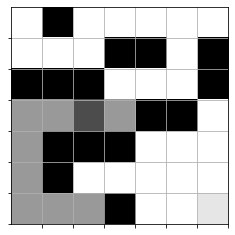

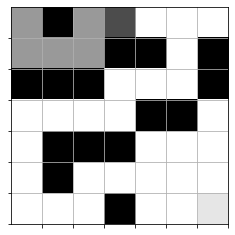

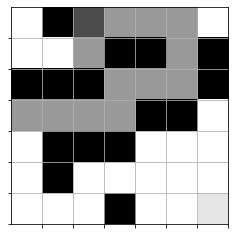

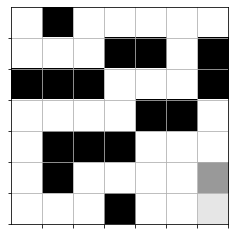

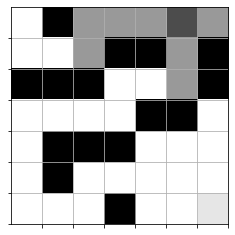

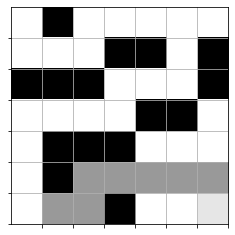

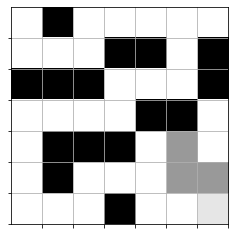

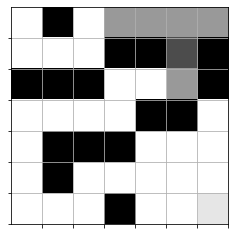

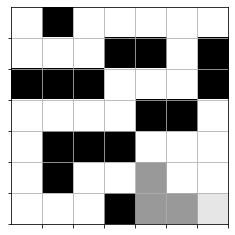

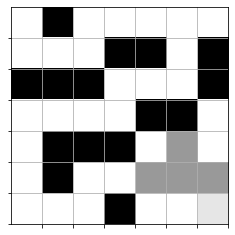

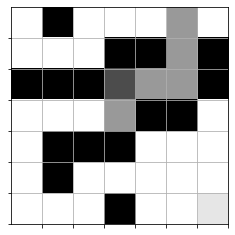

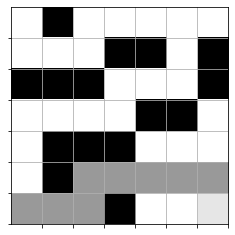

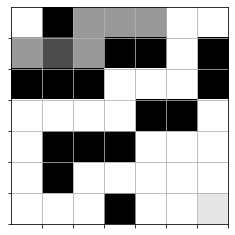

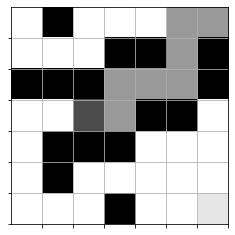

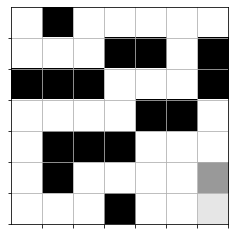

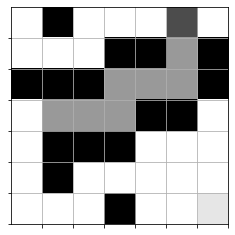

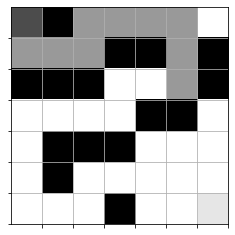

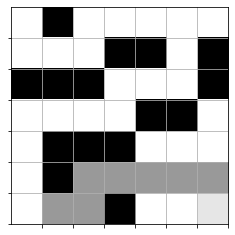

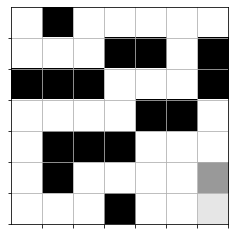

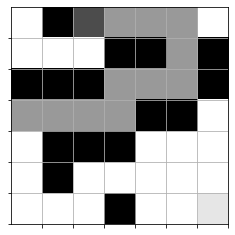

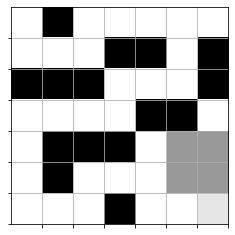

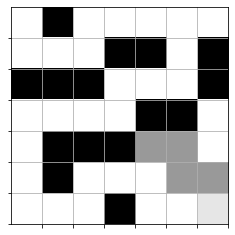

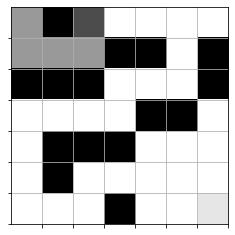

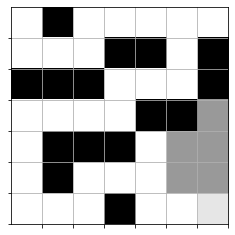

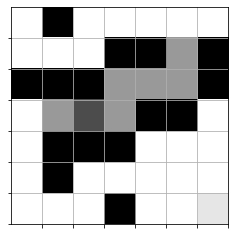

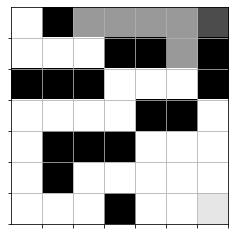

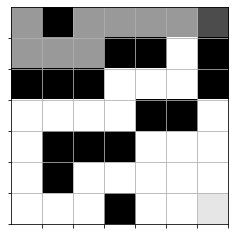

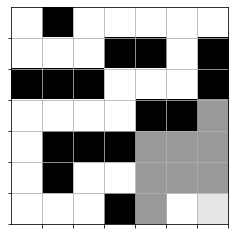

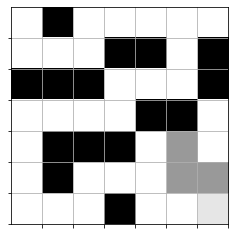

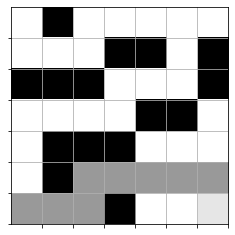

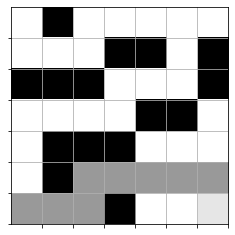

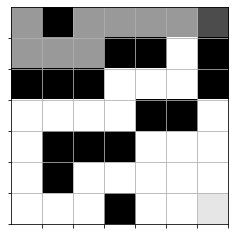

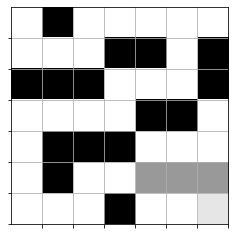

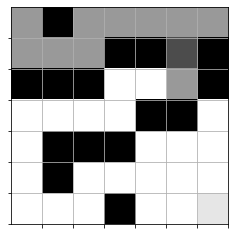

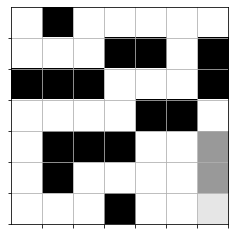

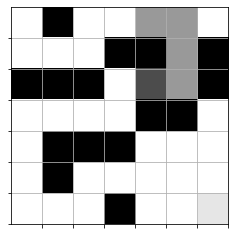

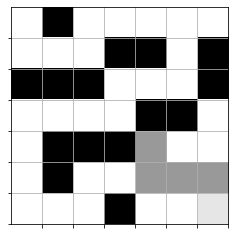

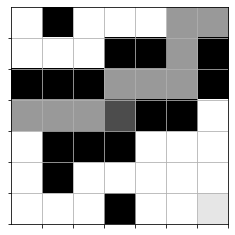

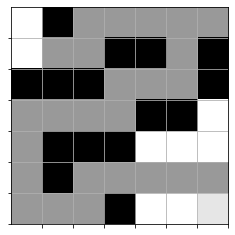

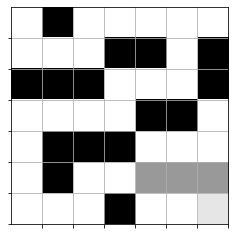

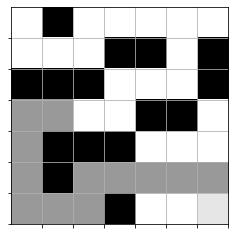

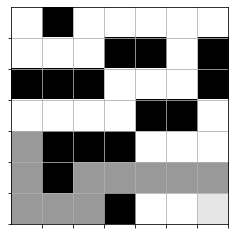

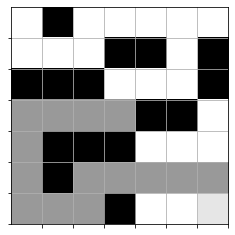

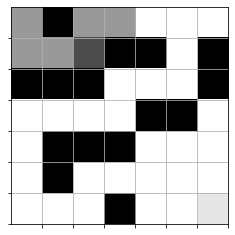

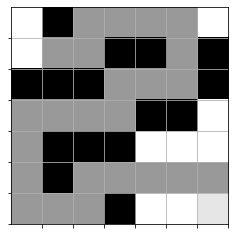

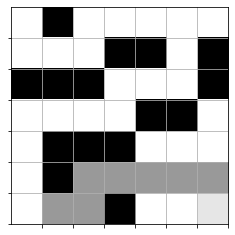

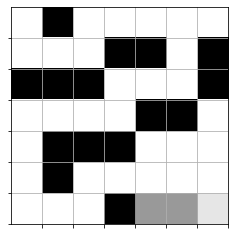

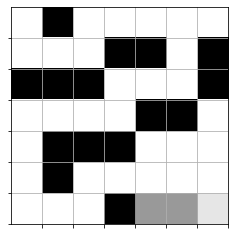

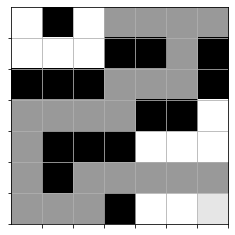

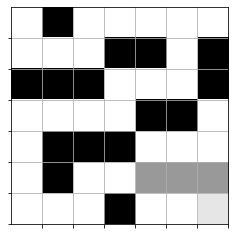

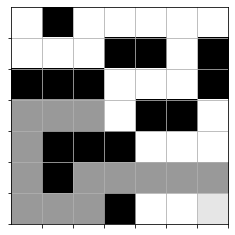

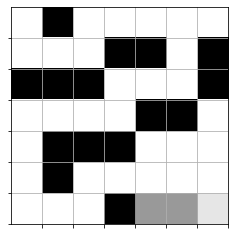

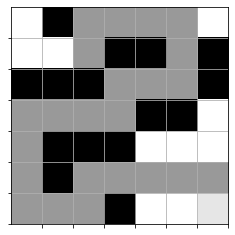

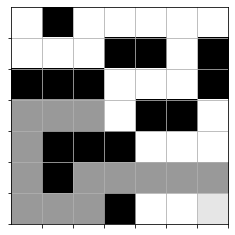

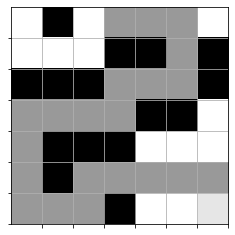

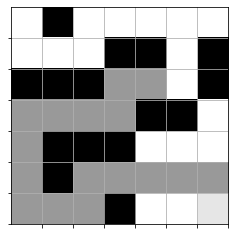

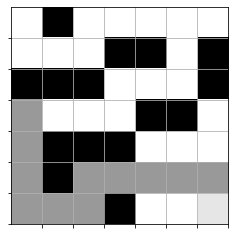

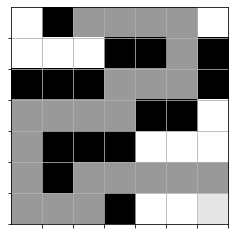

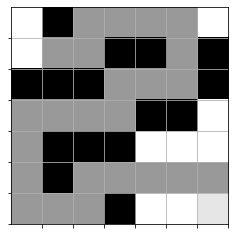

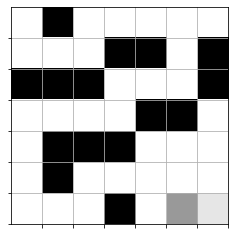

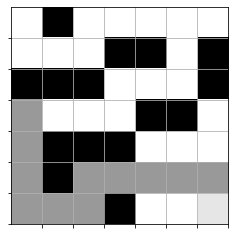

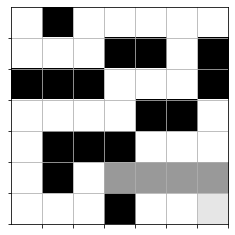

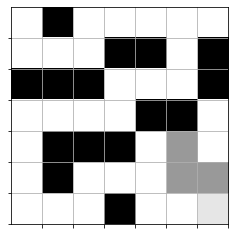

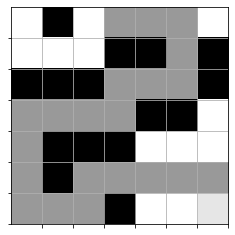

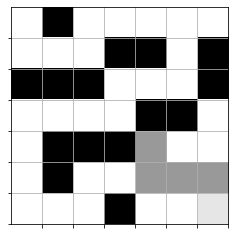

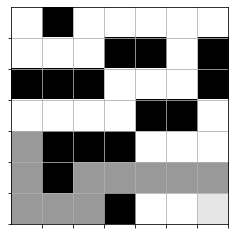

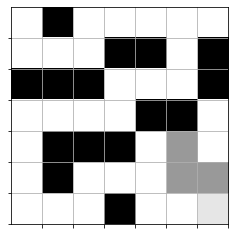

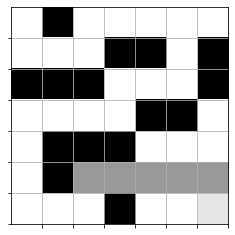

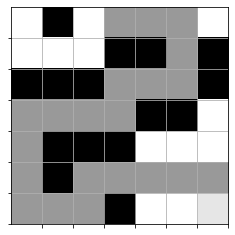

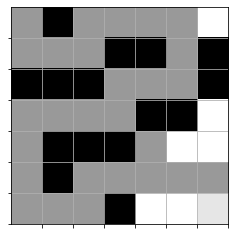

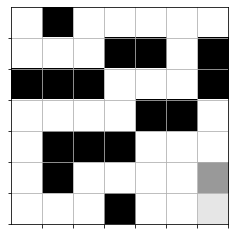

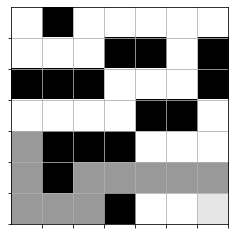

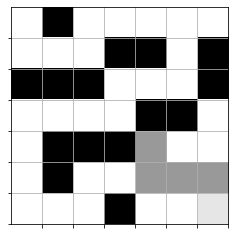

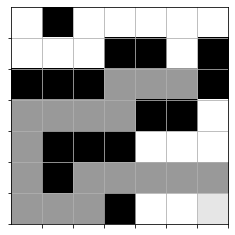

In [29]:
model = build_model(maze)
history=qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)
import matplotlib.pyplot as plt


In [ ]:
import pandas as pd    

df = pd.DataFrame(a1)
df.to_csv('filea.csv', index=False)


In [ ]:
ax1=plt.plot(a1,d1,'g')


plt.xlabel('Epochs')
plt.ylabel('Episodes')

plt.show()

In [ ]:
d1.shape

AttributeError: 'numpy.ndarray' object has no attribute 'maze'

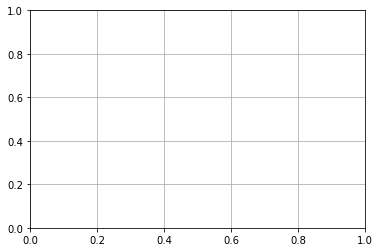

In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np
from keras.models import model_from_json
#from qlearn import Catch


if __name__ == "__main__":
    # Make sure this grid size matches the value used fro training
    grid_size = maze  

    with open("model.json", "r") as jfile:
        model = model_from_json(json.load(jfile))
    model.load_weights("model.h5")
    model.compile("sgd", "mse")

    # Define environment, game
    env = Qmaze(grid_size)
    c = 0
    for e in range(10):
        loss = 0.
        rat=[0,0]
        env.reset(rat)
        game_over = False
        # get initial input
        input_t = env.observe()

      #  plt.imshow(input_t.reshape((grid_size,)*2),
            #interpolation='none', cmap='gray')
        show(grid_size)
        plt.savefig("%03d.png" % c)
        c += 1
        while not game_over:
            input_tm1 = input_t

            # get next action
            q = model.predict(input_tm1)
            action = np.argmax(q[0])

            # apply action, get rewards and new state
            input_t, reward, game_over = env.act(action)

            plt.imshow(input_t.reshape((grid_size,)*2),
                       interpolation='none', cmap='gray')
            plt.savefig("%03d.png" % c)
            c += 1

In [90]:


x_train, x_test, y_train, y_test = train_test_split( images , facial_keypoints , test_size=0.3 )

# Save all the processed data.
np.save( "processed_data/x_train.npy" , x_train )
np.save( "processed_data/y_train.npy" , y_train )
np.save( "processed_data/x_test.npy" , x_test )
np.save( "processed_data/y_test.npy" , y_test )

MemoryError: Unable to allocate 2.21 GiB for an array with shape (3225, 80, 64, 48, 3) and data type uint8

In [101]:
epsilon


0.05

In [19]:
from PIL import Image
import os
import numpy as np

path_to_files = "pics"    
array_of_images = []

for file in enumerate(os.listdir(path_to_files)):
    #if ".jpg" in file: # to check if file has a certain name   
        file = os.path.join(path_to_files,file)
        single_im = Image.open(file)
        single_array = np.array(im)
        array_of_images.append(single_array)            
np.savez("all_images.npz",array_of_images) # save all in one file

TypeError: join() argument must be str or bytes, not 'tuple'

In [15]:
path_to_files

'pics'

In [3]:

from __future__ import print_function
from __future__ import absolute_import
from distutils.dir_util import copy_tree

import os
import sys
import glob
import json
import re
import shutil
from shutil import copytree, ignore_patterns
import numpy as np
input_path='pics'
output_path='shreya1'
CONTEXT_LENGTH = 48
IMAGE_SIZE = 256
BATCH_SIZE = 64
EPOCHS = 10
STEPS_PER_EPOCH = 72000

class Utils:
    @staticmethod
    def sparsify(label_vector, output_size):
        sparse_vector = []

        for label in label_vector:
            sparse_label = np.zeros(output_size)
            sparse_label[label] = 1

            sparse_vector.append(sparse_label)

        return np.array(sparse_vector)

    @staticmethod
    def get_preprocessed_img(img_path, image_size):
        import cv2
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_size, image_size))
        img = img.astype('float32')
        img /= 255
        return img

    @staticmethod
    def show(image):
        import cv2
        cv2.namedWindow("view", cv2.WINDOW_AUTOSIZE)
        cv2.imshow("view", image)
        cv2.waitKey(0)
        cv2.destroyWindow("view")

print("Converting images to numpy arrays...")

for f in os.listdir(input_path):
    if f.find(".png") != -1:
        img = Utils.get_preprocessed_img("{}/{}".format(input_path, f), IMAGE_SIZE)
        file_name = f[:f.find(".png")]

        np.savez_compressed("{}/{}".format(output_path, file_name), features=img)
        retrieve = np.load("{}/{}.npz".format(output_path, file_name))["features"]

        assert np.array_equal(img, retrieve)

     #   shutil.copyfile("{}/{}.gui".format(input_path, file_name), "{}/{}.gui".format(output_path, file_name))

print("Numpy arrays saved in {}".format(output_path))

Converting images to numpy arrays...
Numpy arrays saved in shreya1


In [26]:
from PIL import Image
import numpy as np
inp='pics'
for file in inp:
    img = Image.open("file.png")
    arr = np.array(img)

FileNotFoundError: [Errno 2] No such file or directory: 'file.png'

In [2]:
x_train = np.load( "face_landmarks_cleaned/x_train.npy" ) / 255
y_train = np.load( "face_landmarks_cleaned/y_train.npy" ) / 96
x_test = np.load( "face_landmarks_cleaned/x_test.npy" ) / 255
y_test = np.load( "face_landmarks_cleaned/y_test.npy" ) / 96

y_train = np.reshape( y_train , ( -1 , 1 , 1 , 30 ))
y_test = np.reshape( y_test , ( -1 , 1 , 1 , 30 ))

In [1]:
!wget https://github.com/shubham0204/Dataset_Archives/blob/master/face_landmarks_cleaned.zip?raw=true -O data.zip
!unzip data.zip

--2020-05-16 14:11:10--  https://github.com/shubham0204/Dataset_Archives/blob/master/face_landmarks_cleaned.zip?raw=true
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/shubham0204/Dataset_Archives/raw/master/face_landmarks_cleaned.zip [following]
--2020-05-16 14:11:10--  https://github.com/shubham0204/Dataset_Archives/raw/master/face_landmarks_cleaned.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/face_landmarks_cleaned.zip [following]
--2020-05-16 14:11:10--  https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/face_landmarks_cleaned.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|15

 17850K .......... .......... .......... .......... .......... 77% 12,2M 1s
 17900K .......... .......... .......... .......... .......... 77% 7,04M 1s
 17950K .......... .......... .......... .......... .......... 77% 5,41M 1s
 18000K .......... .......... .......... .......... .......... 77% 5,58M 1s
 18050K .......... .......... .......... .......... .......... 78% 7,48M 1s
 18100K .......... .......... .......... .......... .......... 78% 6,47M 1s
 18150K .......... .......... .......... .......... .......... 78% 7,09M 1s
 18200K .......... .......... .......... .......... .......... 78% 7,63M 1s
 18250K .......... .......... .......... .......... .......... 78% 2,85M 1s
 18300K .......... .......... .......... .......... .......... 79% 11,3M 1s
 18350K .......... .......... .......... .......... .......... 79% 4,50M 1s
 18400K .......... .......... .......... .......... .......... 79% 7,64M 1s
 18450K .......... .......... .......... .......... .......... 79% 4,03M 1s
 18500K ....

In [4]:
import tensorflow as tf
import numpy as np

In [6]:
!wget https://github.com/shubham0204/Dataset_Archives/blob/master/face_landmarks_cleaned.zip?raw=true -O data.zip
!unzip data.zip

--2020-05-16 14:16:38--  https://github.com/shubham0204/Dataset_Archives/blob/master/face_landmarks_cleaned.zip?raw=true
Resolving github.com (github.com)... 140.82.118.4
Connecting to github.com (github.com)|140.82.118.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/shubham0204/Dataset_Archives/raw/master/face_landmarks_cleaned.zip [following]
--2020-05-16 14:16:39--  https://github.com/shubham0204/Dataset_Archives/raw/master/face_landmarks_cleaned.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/face_landmarks_cleaned.zip [following]
--2020-05-16 14:16:39--  https://raw.githubusercontent.com/shubham0204/Dataset_Archives/master/face_landmarks_cleaned.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.84.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|15

  5050K .......... .......... .......... .......... .......... 22% 8,10M 3s
  5100K .......... .......... .......... .......... .......... 22% 7,51M 3s
  5150K .......... .......... .......... .......... .......... 22% 6,90M 3s
  5200K .......... .......... .......... .......... .......... 22% 7,09M 3s
  5250K .......... .......... .......... .......... .......... 22% 7,62M 3s
  5300K .......... .......... .......... .......... .......... 23% 6,27M 3s
  5350K .......... .......... .......... .......... .......... 23% 5,90M 3s
  5400K .......... .......... .......... .......... .......... 23% 7,03M 3s
  5450K .......... .......... .......... .......... .......... 23% 3,38M 3s
  5500K .......... .......... .......... .......... .......... 23% 7,31M 3s
  5550K .......... .......... .......... .......... .......... 24% 6,78M 3s
  5600K .......... .......... .......... .......... .......... 24% 3,28M 3s
  5650K .......... .......... .......... .......... .......... 24% 6,21M 3s
  5700K ....

In [9]:
!unzip data.zip

'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
x_train = np.load( "face_landmarks_cleaned/x_train.npy" ) / 255
y_train = np.load( "face_landmarks_cleaned/y_train.npy" ) / 96
x_test = np.load( "face_landmarks_cleaned/x_test.npy" ) / 255
y_test = np.load( "face_landmarks_cleaned/y_test.npy" ) / 96

y_train = np.reshape( y_train , ( -1 , 1 , 1 , 30 ))
y_test = np.reshape( y_test , ( -1 , 1 , 1 , 30 ))

In [4]:
model_layers = [ 
    tf.keras.layers.Conv2D( 128 , input_shape=( 96 , 96 , 1 ) , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 128 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 32 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' ),
    #tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D( 30 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 30 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 30 , kernel_size=( 2 , 2 ) , strides=1 , activation='relu' ),
    tf.keras.layers.Conv2D( 30 , kernel_size=( 2 , 2 ) , strides=1 , activation='sigmoid' ),

]
model = tf.keras.Sequential( model_layers )
model.compile( loss=tf.keras.losses.mean_squared_error , optimizer=tf.keras.optimizers.Adam( lr=0.0001 ) , metrics=[ 'mse' ] )
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 92, 92, 128)       3328      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 88, 88, 128)       409728    
_________________________________________________________________
batch_normalization (BatchNo (None, 88, 88, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 84, 84, 128)       409728    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 80, 80, 128)       409728    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 76, 76, 128)       409728    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 128)       4

In [5]:
model.fit( x_train , y_train , epochs=5 , batch_size=50 , validation_data=( x_test , y_test ) )

Train on 1498 samples, validate on 642 samples
Epoch 1/5
1498/1498 [==============================] - 1673s 1s/sample - loss: 0.0357 - mse: 0.0357 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 2/5
1498/1498 [==============================] - 1691s 1s/sample - loss: 0.0262 - mse: 0.0262 - val_loss: 0.0311 - val_mse: 0.0311
Epoch 3/5
1498/1498 [==============================] - 1690s 1s/sample - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0225 - val_mse: 0.0225
Epoch 4/5
1498/1498 [==============================] - 1625s 1s/sample - loss: 0.0049 - mse: 0.0049 - val_loss: 0.0155 - val_mse: 0.0155
Epoch 5/5
1498/1498 [==============================] - 1814s 1s/sample - loss: 0.0021 - mse: 0.0021 - val_loss: 0.0109 - val_mse: 0.0109


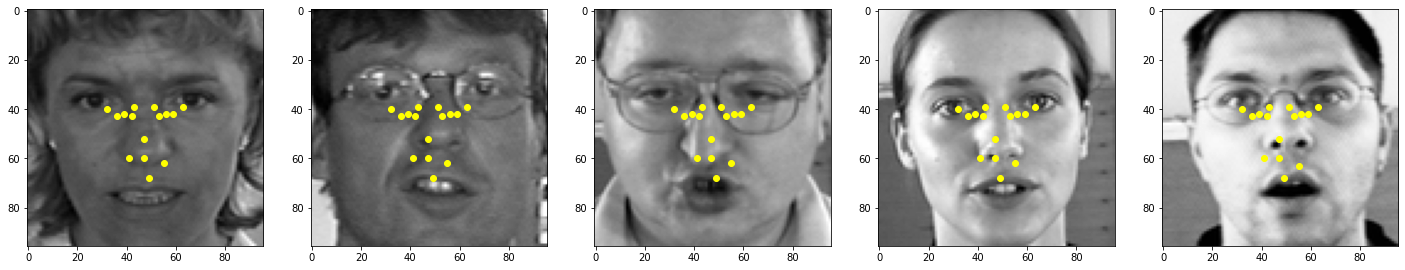

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=( 50 , 50 ))

for i in range( 1 , 6 ):
    sample_image = np.reshape( x_test[i] * 255  , ( 96 , 96 ) ).astype( np.uint8 )
    pred = model.predict( x_test[ i : i +1  ] ) * 96
    pred = pred.astype( np.int32 )
    pred = np.reshape( pred[0 , 0 , 0 ] , ( 15 , 2 ) )
    fig.add_subplot( 1 , 10 , i )
    plt.imshow( sample_image.T , cmap='gray' )
    plt.scatter( pred[ : , 0 ] , pred[ : , 1 ] , c='yellow' )
    
plt.show()

In [9]:
from IPython.display import display, Javascript
#from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [13]:
import cv2
import numpy as np

# For Visualization in Jupyter
import ipywidgets as widgets
from matplotlib import pyplot as plt
from IPython.display import display

# Get images and video into Jupyter from your webcam
from ipywebrtc import CameraStream, ImageRecorder, VideoRecorder
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [14]:
recorder = ImageRecorder(stream=camera)
recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

In [15]:
camera.close()

In [18]:
# extract the value from the ImageRecorder
snapshot = recorder.image.value
#snapshot = np.frombuffer(snapshot, dtype=np.uint8)
#snapshot = cv2.imdecode(snapshot, cv2.IMREAD_COLOR)

In [19]:

from IPython.display import Image
try:
  filename = snapshot()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

'bytes' object is not callable


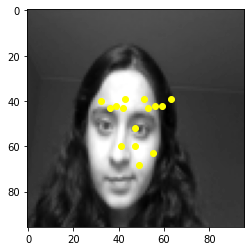

In [21]:
from PIL import Image
import matplotlib.pyplot as plt

image = Image.open( "snapshot.png").convert('L').resize( ( 96 , 96 ) ).rotate( 90 )
image_arr = np.asarray( image ) / 255

pred = model.predict( np.array( [ image_arr.reshape( 96 , 96 , 1 ) ] ) ) * 96
pred = pred.astype( np.int32 )
pred = np.reshape( pred[0 , 0 , 0 ] , ( 15 , 2 ) )

plt.imshow( image_arr.T , cmap='gray' )
plt.scatter( pred[ : , 0 ] , pred[ : , 1 ] , c='yellow' )
plt.show()


In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Download the dataset from Kaggle. Unzip the archive. You'll find the facial_keypoints.csv file there.
facial_keypoints = pd.read_csv( "facial_keypoints.csv")
num_missing_keypoints = facial_keypoints.isnull().sum( axis=1 )
all_keypoints_present_ids = np.nonzero( num_missing_keypoints == 0 )[ 0 ]

# face_images.npz is present the same archive.
d = np.load( "files/face-images-with-marked-landmark-points/face_images.npz")
dataset = d[ 'face_images' ].T
dataset = np.reshape( dataset , ( -1 , 96 , 96 , 1 ) )

images = dataset[  all_keypoints_present_ids , : , : , : ]
keypoints = facial_keypoints.iloc[ all_keypoints_present_ids , : ].reset_index( drop=True ).values

x_train, x_test, y_train, y_test = train_test_split( images , keypoints , test_size=0.3 )

# Save all the processed data.
np.save( "processed_data/x_train.npy" , x_train )
np.save( "processed_data/y_train.npy" , y_train )
np.save( "processed_data/x_test.npy" , x_test )
np.save( "processed_data/y_test.npy" , y_test )

ValueError: Length of passed values is 1, index implies 7049.

In [41]:
all_keypoints_present_ids.shape

NameError: name 'all_keypoints_present_ids' is not defined

In [43]:
num_missing_keypoints = facial_keypoints.isnull().sum( axis=1 )

In [45]:
num_missing_keypoints.shape

(7049,)

In [72]:
var_name = np.load("y_train.npy")


In [73]:
var_name.shape

(1498, 30)

In [49]:
dataset.shape

(10747, 64, 48, 3)

In [81]:
a = np.load("y_train.npy")

In [82]:
type(k)

numpy.ndarray

In [70]:
x_train=dataset[0:7000,:,:,:]

In [71]:
x_train.shape

(7000, 64, 48, 3)

In [83]:
type(facial_keypoints)

pandas.core.frame.DataFrame

In [86]:
import csv
import numpy as np

csv_fn = "rounded_csv.csv"

with open(csv_fn, "rb") as infile:
    reader = csv.reader(infile)
    next(reader, None)         # Skips the header? 
    x = list(reader) 
    result = np.array(x).astype("int")

Error: iterator should return strings, not bytes (did you open the file in text mode?)

In [80]:
y_train=facial_keypoints[0:7000,]

TypeError: '(slice(0, 7000, None), slice(0, 80, None))' is an invalid key

In [67]:
x_train

array([[[ 97,  78,  81, ...,  78,  80,  77],
        [ 78,  80,  82, ...,  73,  73,  73],
        [ 73,  75,  75, ...,  73,  76,  73],
        ...,
        [108, 104, 106, ..., 106, 104, 104],
        [111, 109, 107, ..., 106, 106, 109],
        [106, 109, 106, ..., 108, 116, 113]],

       [[110, 110, 113, ..., 104, 103, 101],
        [102, 103, 106, ..., 103, 118, 110],
        [114, 114, 116, ..., 104, 111, 113],
        ...,
        [123, 121, 123, ...,  40, 122,  41],
        [ 42,  42,  45, ..., 124, 122, 126],
        [124, 124, 121, ..., 126, 126, 126]],

       [[126, 126, 122, ..., 121, 121, 122],
        [122, 121, 122, ..., 120, 120, 118],
        [120, 120, 120, ..., 117, 120, 121],
        ...,
        [165, 167, 167, ..., 168, 168, 169],
        [168, 169, 169, ...,  35,  38,  38],
        [ 40,  36,  36, ...,  38,  39,  39]],

       ...,

       [[ 37,  57,  59, ..., 124, 126, 124],
        [ 52, 125, 126, ..., 125, 129, 125],
        [127, 126, 126, ...,  62,  85,  81